# TP: Support Vector Machine (SVM)

#### Margaux NICOLAS | Jeanne MALÉCOT
---
---

##### _Imports_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

## Preliminary questions

**1) Show that the primal problem solved by the SVM can be rewritten as follows :**

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
           <b> Answer:</b>
            
</div>


>We know the two following constraints : $\xi_i \geq 0$ and $\xi_i \geq 1 - y_i(\langle w, \Phi(x_i)\rangle + \omega_0)$.  
It gives us :  
>$$ 
\begin{align}
\xi_i &\geq max(0,1- y_i(\langle w, \Phi(x_i)\rangle + \omega_0)) \\
&\geq [1- y_i(\langle w, \Phi(x_i)\rangle + \omega_0)]_+
\end{align}
>$$
>We can thus rewritten the primal problem in the way requested above.


---
**2) Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.**

<div class='alert alert-block alert-warning'>
           <b> Answer:</b></div>

>We can justify the fact that we are using a convex upper bound because :
>- All the function of the $argmin$ are convex
>- $ x 	\mapsto [1-x]_+$ is a loss function  
>
>The difference between the two loss fuction is that, in the case of an error :
>
>- The **Binary loss** fuction will return $1$
>- The **Hinge loss** will return $1 - y_i(\langle w, \Phi(x_i)\rangle + \omega_0)$, and in this case we know that $y_i(\langle w, \Phi(x_i)\rangle + \omega_0) < 0$  
>
>The result of the **Hinge loss** will thus be greater than $1$.  
We conclude that the **Hinge loss** is a upper bound of the **Binary loss**.
>
>(_Both losses return 0 if we don't have an error_)



---
---
## Example of using the SVC class from scikit-learn

In [2]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 1.0
Testing score : 0.95


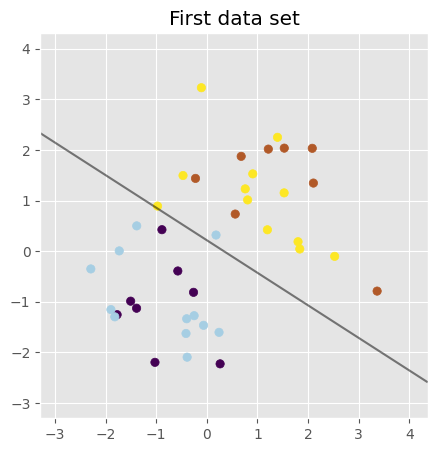

In [3]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()


## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

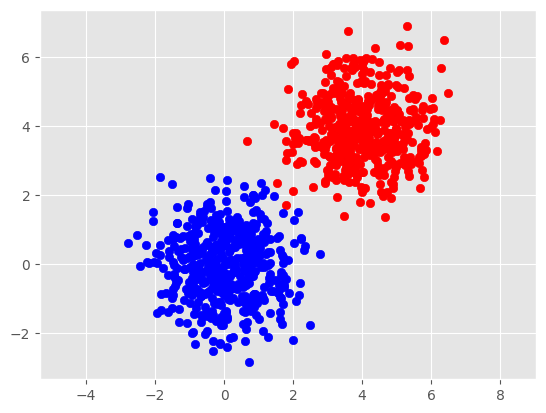

In [4]:
# Create two centers for the two distributions 
centers = np.array([[0,0],[4,4]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples = 1000, centers = centers, cluster_std = 1, n_features = 2)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [5]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = 1000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = np.random.rand()# Random binary choice: will the point be generated from the first or second gaussian ? 
    if rand<1/2:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2),1)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2),1)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers[0],cov=np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers[1],cov=np.eye(2))
    # Compute the risk from these and add it to the total
    eta = p1/(p1+p2)
    R = min(eta, 1-eta)
    expectation += R

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.001
Estimated Bayes accuracy: 0.999


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 0.9986666666666667/1.0


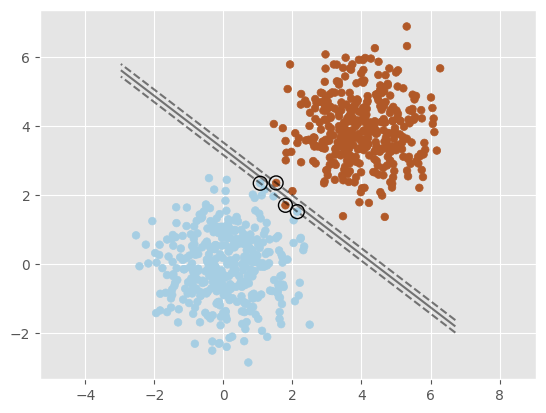

In [7]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

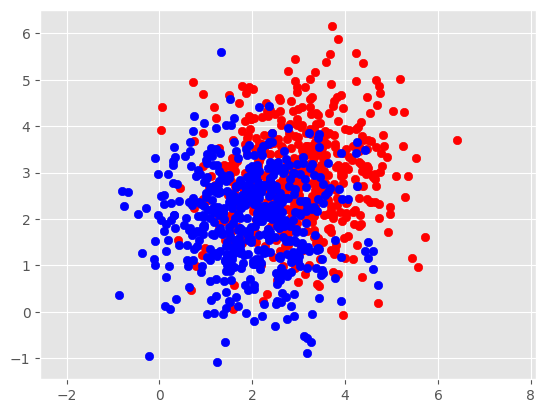

In [8]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
# Create two centers for the two distributions 
centers_overlap = np.array([[2,2],[3,3]])

# Use make_blobs to generate the two dimensions points from the two centers
X_overlap, y_overlap = make_blobs(n_samples = 1000, centers = centers_overlap, cluster_std = 1, n_features = 2)

# Plot the points 
pos = np.where(y_overlap == 1)[0]
neg = np.where(y_overlap == 0)[0]
plt.scatter(X_overlap[pos,0], X_overlap[pos,1], c='r')
plt.scatter(X_overlap[neg,0], X_overlap[neg,1], c='b')
plt.axis('equal')
plt.show()

# Use sklearn's train_test_split to divide up data
X_train_overlap, X_test_overlap, y_train_overlap, y_test_overlap = train_test_split(X_overlap, y_overlap, test_size=0.25)

Train/Test scores: 0.756/0.744


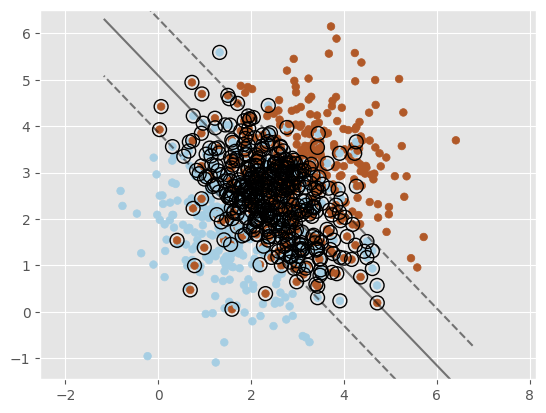

In [9]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear')
clf.fit(X_train_overlap, y_train_overlap)
print(f'Train/Test scores: {clf.score(X_train_overlap, y_train_overlap)}/{clf.score(X_test_overlap, y_test_overlap)}')

# Plot the data
plt.scatter(X_train_overlap[:, 0], X_train_overlap[:, 1], c=y_train_overlap, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

In [10]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf_overlap = GridSearchCV(clf, parameters, return_train_score=True)
clf_overlap.fit(X_train_overlap, y_train_overlap)
C_star = clf_overlap.get_params()['estimator__C']
C_best_param = clf_overlap.best_params_['C']

print(C_star)
print("Meilleur paramètre donné par best_params_ : ", C_best_param)

1.0
Meilleur paramètre donné par best_params_ :  0.03162277660168379


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
clf_overlap_gauss = svm.SVC(kernel = 'rbf', C=1000)
parameters = {'gamma' : gammas}
clf_overlap_gauss = GridSearchCV(clf_overlap_gauss, parameters, return_train_score= True)
clf_overlap_gauss.fit(X_overlap,y_overlap)
mean_train = clf_overlap_gauss.cv_results_['mean_train_score']
mean_test = clf_overlap_gauss.cv_results_['mean_test_score']

print('difference between the mean testing and training score : ', np.mean(mean_train-mean_test))

difference between the mean testing and training score :  0.17500000000000002


## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

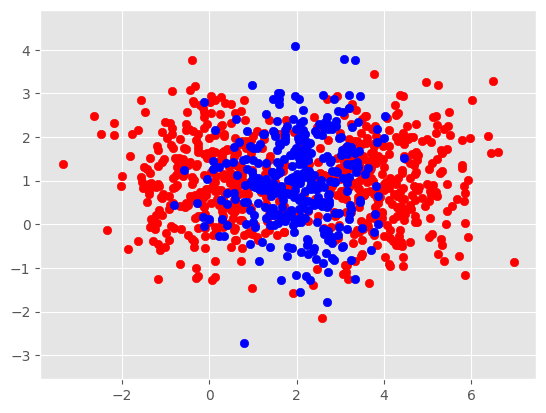

In [12]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

centers_nl= np.array([[0,1],[2,1],[4,1]])

# Use make_blobs to generate the two dimensions points from the two centers
X_nl, y_nl = make_blobs(n_samples = 1000, centers = centers_nl, cluster_std = 1, n_features = 3)

y_nl = 1 - np.abs(y_nl-1)
# Plot the points 
c_0 = np.where(y_nl == 0)[0]
c_1 = np.where(y_nl == 1)[0]
plt.scatter(X_nl[c_0,0], X_nl[c_0,1], c='r')
plt.scatter(X_nl[c_1,0], X_nl[c_1,1], c='b')
plt.axis('equal')
plt.show()

# Use sklearn's train_test_split to divide up data
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl, y_nl, test_size=0.25)


**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

LINEAR CASE :

Train/Test scores: 0.6626666666666666/0.68


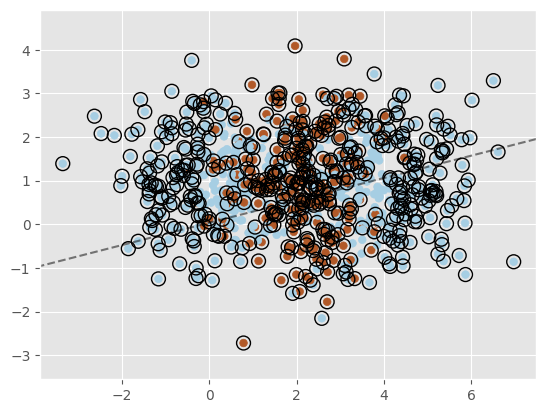

In [13]:
# Use the code of question 6 again
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear')
clf.fit(X_train_nl, y_train_nl)
print(f'Train/Test scores: {clf.score(X_train_nl, y_train_nl)}/{clf.score(X_test_nl, y_test_nl)}')

# Plot the data
plt.scatter(X_train_nl[:, 0], X_train_nl[:, 1], c=y_train_nl, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

In [38]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf_nl = GridSearchCV(clf, parameters, return_train_score=True)
clf_nl.fit(X_train_nl, y_train_nl)
C_star = clf_overlap.get_params()['estimator__C']
C_best_param = clf_overlap.best_params_['C']

print(C_star)
print("Meilleur paramètre donné par best_params_ : ", C_best_param)

Nous avons relancé la cellule involontairement : nous n'avons pas le temps de laisser tourner à nouveau 5min, nous avions trouvé pour les deux C les valeurs 1.0 et 1.0

GAUSSIAN CASE :

Train/Test scores: 0.792/0.816


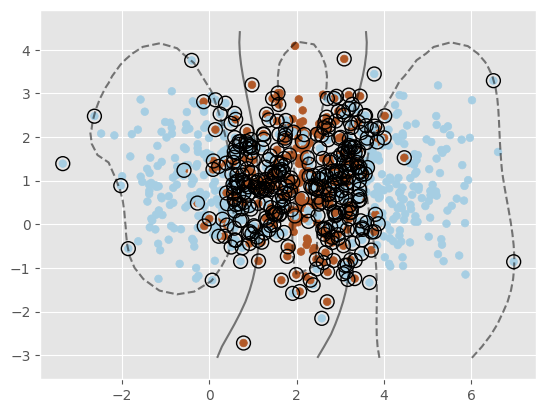

In [14]:
# Create a gaussian SVM and train it on the training data
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_nl, y_train_nl)
print(f'Train/Test scores: {clf.score(X_train_nl, y_train_nl)}/{clf.score(X_test_nl, y_test_nl)}')

# Plot the data
plt.scatter(X_train_nl[:, 0], X_train_nl[:, 1], c=y_train_nl, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

In [28]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
clf_nl = GridSearchCV(clf, parameters, return_train_score=True)
clf_nl.fit(X_train_nl, y_train_nl)
C_star = clf_nl.get_params()['estimator__C']
C_best_param = clf_overlap.best_params_['C']

print(C_star)
print("Meilleur paramètre donné par best_params_ : ", C_best_param)

1.0
Meilleur paramètre donné par best_params_ :  0.03162277660168379


La première fois que nous avions exécuté la cellule, nous avions obtenu 1.0 pour best_params_ ; nous ne comprenons pas pourquoi le résultat a changé après avoir re-run tout le notebook.

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

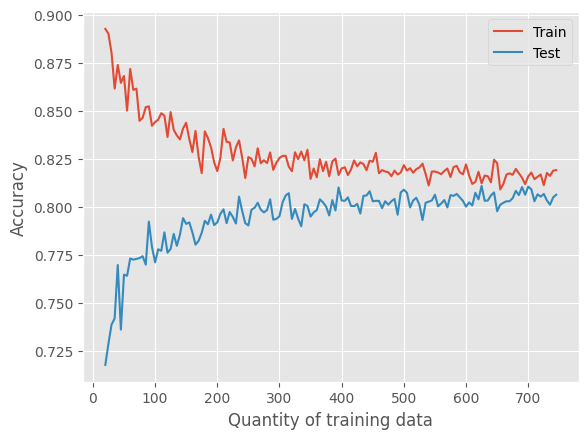

In [33]:
# Total number of training samples
n_tr = len(X_train_nl)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf_svm = svm.SVC(kernel='rbf', gamma=1.0, C=1.0)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train_nl[idx, :]
        y_train_reduced = y_train_nl[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf_svm.fit(X_train_reduced, y_train_reduced)
        score_train += clf_svm.score(X_train_reduced, y_train_reduced)
        score_test += clf_svm.score(X_test_nl, y_test_nl)
    # Add the average of the scores to the lists
    scores_train.append(score_train/n_m)
    scores_test.append(score_test/n_m)

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [35]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 

n_mc = 1000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = np.random.rand()# Random binary choice: will the point be generated from the first or second gaussian ? 
    if rand<1/3:
        # First case: y = 0
        x = np.random.multivariate_normal(centers_nl[0], np.eye(2),1)
    elif rand>=1/3 and rand <2/3:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers_nl[1], np.eye(2),1)
    else :
        x = np.random.multivariate_normal(centers_nl[2], np.eye(2),1)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=centers_nl[0],cov=np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers_nl[1],cov=np.eye(2))
    p3 = multivariate_normal.pdf(x, mean=centers_nl[2],cov=np.eye(2))
    # Compute the risk from these and add it to the total
    eta = p1/(p1+p2+p3)
    R = min(eta, 1-eta)
    expectation += R

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.102
Estimated Bayes accuracy: 0.898


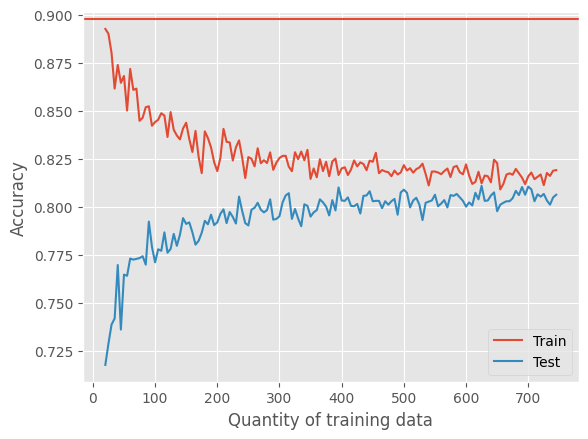

In [37]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.axhline(1-expectation)
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

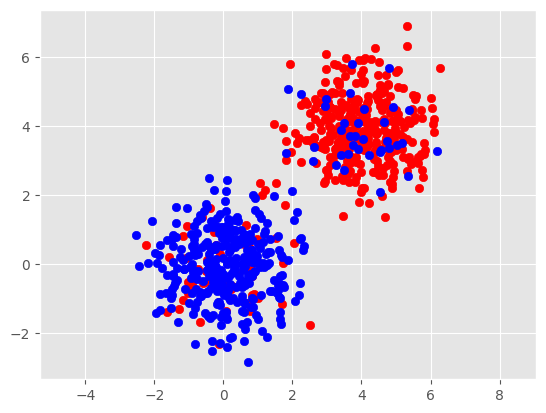

In [38]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

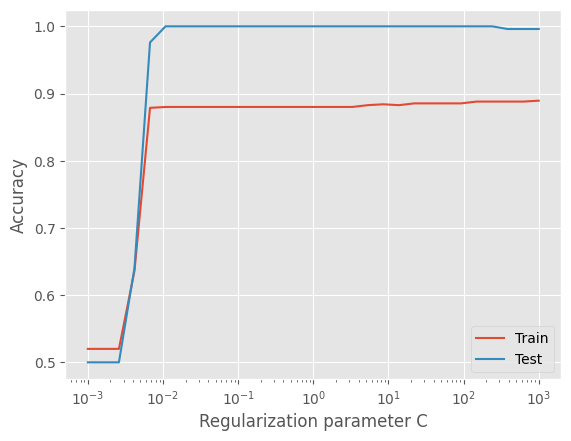

In [42]:
# Vary the appropriate parameter and plot the training/testing results
# Create arrays of C values to try


#To vary the appropriate parameter and plot the training/testing results, we can modify the hyper-parameter controlling the complexity of the SVM, such as the regularization parameter C
C_values = np.logspace(-3, 3, 30)
n_C = len(C_values)

scores_train = []
scores_test = []

for i in range(n_C):
    clf = svm.SVC(kernel='rbf', C=C_values[i], gamma='auto')

    clf.fit(X_train, y_train)
    
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    
    scores_train.append(score_train)
    scores_test.append(score_test)

# Plot the results
plt.semilogx(C_values, scores_train, label='Train')
plt.semilogx(C_values, scores_test, label='Test')
plt.xlabel('Regularization parameter C')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [ ]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA
